<a href="https://colab.research.google.com/github/YaromirKo/3D_convolutional_neural_network/blob/master/gw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!ls drive/My\ Drive

'Colab Notebooks'   pix2pix_weights  'Yaromir Kobikov (1).gdoc'
 datasets	    statistic.csv    'Yaromir Kobikov.gdoc'


In [0]:
!cp './drive/My Drive/datasets/dataset_figure.zip' .

In [0]:
!unzip dataset_figure.zip

In [0]:
!pip install plotly==4.6.0

     |████████████████████████████████| 7.2MB 2.7MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [0]:
!pip install pyntcloud

     |████████████████████████████████| 348kB 2.8MB/s 


In [0]:
"""
VoxelGrid Class
"""
import numpy as np
from matplotlib import pyplot as plt

class VoxelGrid(object):
    
    def __init__(self, points, x_y_z=[1, 1, 1], bb_cuboid=True, build=True):
        """
        Parameters
        ----------         
        points: (N,3) ndarray
                The point cloud from wich we want to construct the VoxelGrid.
                Where N is the number of points in the point cloud and the second
                dimension represents the x, y and z coordinates of each point.
        
        x_y_z:  list
                The segments in wich each axis will be divided.
                x_y_z[0]: x axis 
                x_y_z[1]: y axis 
                x_y_z[2]: z axis

        bb_cuboid(Optional): bool
                If True(Default):   
                    The bounding box of the point cloud will be adjusted
                    in order to have all the dimensions of equal lenght.                
                If False:
                    The bounding box is allowed to have dimensions of different sizes.
        """
        self.points = points

        xyzmin = np.min(points, axis=0) - 0.001
        xyzmax = np.max(points, axis=0) + 0.001

        if bb_cuboid:
            #: adjust to obtain a  minimum bounding box with all sides of equal lenght 
            diff = max(xyzmax-xyzmin) - (xyzmax-xyzmin)
            xyzmin = xyzmin - diff / 2
            xyzmax = xyzmax + diff / 2
        
        self.xyzmin = xyzmin
        self.xyzmax = xyzmax

        segments = []
        shape = []

        for i in range(3):
            # note the +1 in num 
            if type(x_y_z[i]) is not int:
                raise TypeError("x_y_z[{}] must be int".format(i))
            s, step = np.linspace(xyzmin[i], xyzmax[i], num=(x_y_z[i] + 1), retstep=True)
            segments.append(s)
            shape.append(step)
        
        self.segments = segments

        self.shape = shape

        self.n_voxels = x_y_z[0] * x_y_z[1] * x_y_z[2]
        self.n_x = x_y_z[0]
        self.n_y = x_y_z[1]
        self.n_z = x_y_z[2]
        
        self.id = "{},{},{}-{}".format(x_y_z[0], x_y_z[1], x_y_z[2], bb_cuboid)

        if build:
            self.build()


    def build(self):

        structure = np.zeros((len(self.points), 4), dtype=int)

        structure[:,0] = np.searchsorted(self.segments[0], self.points[:,0]) - 1

        structure[:,1] = np.searchsorted(self.segments[1], self.points[:,1]) - 1

        structure[:,2] = np.searchsorted(self.segments[2], self.points[:,2]) - 1

        # i = ((y * n_x) + x) + (z * (n_x * n_y))
        structure[:,3] = ((structure[:,1] * self.n_x) + structure[:,0]) + (structure[:,2] * (self.n_x * self.n_y)) 
        
        self.structure = structure

        vector = np.zeros(self.n_voxels)
        count = np.bincount(self.structure[:,3])
        vector[:len(count)] = count

        self.vector = vector.reshape(self.n_z, self.n_y, self.n_x)

 
    def plot(self, d=2, cmap="Oranges", axis=False):

        if d == 2:

            fig, axes= plt.subplots(int(np.ceil(self.n_z / 4)), 4, figsize=(8,8))

            plt.tight_layout()

            for i,ax in enumerate(axes.flat):
                if i >= len(self.vector):
                    break
                im = ax.imshow(self.vector[i], cmap=cmap, interpolation="none")
                ax.set_title("Level " + str(i))

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label('NUMBER OF POINTS IN VOXEL')

In [0]:
from pyntcloud import PyntCloud
import pandas as pd
import numpy as np

torus = PyntCloud.from_file("dataset_figure/torus/torus_0.ply")
cloud_points_torus = torus.get_sample("mesh_random", n=10000, as_PyntCloud=True)
new_format_voxel = pd.DataFrame({"x": cloud_points_torus.points['x'], "y": cloud_points_torus.points['y'], "z":cloud_points_torus.points['z']}).to_numpy() 
voxel_grid_torus = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])

cone = PyntCloud.from_file("dataset_figure/cone/cone_0.ply")
cloud_points_cone = cone.get_sample("mesh_random", n=10000, as_PyntCloud=True)
new_format_voxel = pd.DataFrame({"x": cloud_points_cone.points['x'], "y": cloud_points_cone.points['y'], "z":cloud_points_cone.points['z']}).to_numpy() 
voxel_grid_cone = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])

sphere = PyntCloud.from_file("dataset_figure/sphere/sphere_0.ply")
cloud_points_sphere = sphere.get_sample("mesh_random", n=10000, as_PyntCloud=True)
new_format_voxel = pd.DataFrame({"x": cloud_points_sphere.points['x'], "y": cloud_points_sphere.points['y'], "z":cloud_points_sphere.points['z']}).to_numpy() 
voxel_grid_sphere = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])


None
None
None


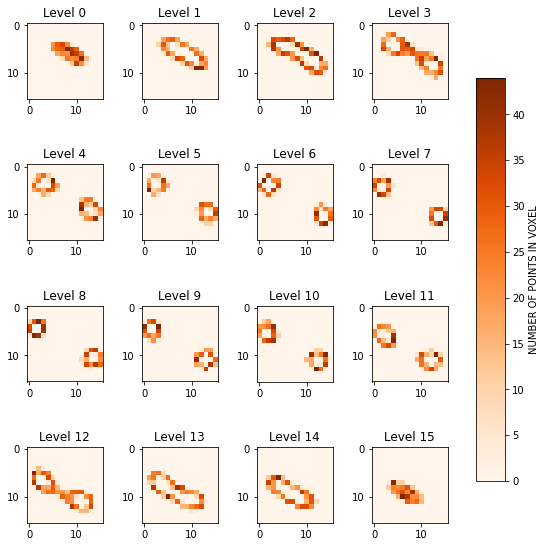

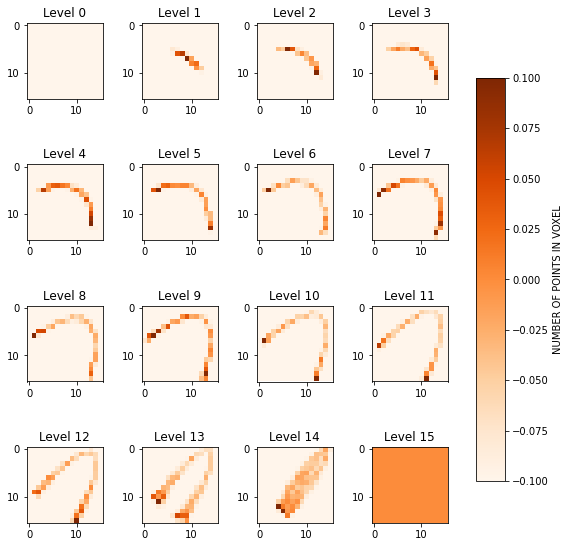

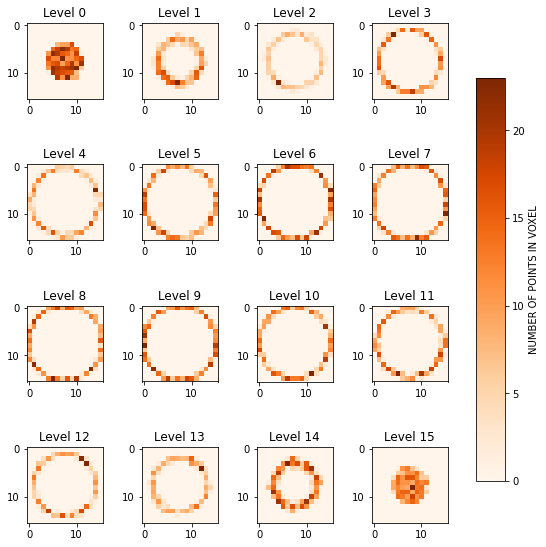

In [0]:
print(voxel_grid_torus.plot())
print(voxel_grid_cone.plot())
print(voxel_grid_sphere.plot())


In [0]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=torus.points['x'],
    y=torus.points['y'],
    z=torus.points['z'],
    mode='markers',
    marker=dict(
        size=2,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [0]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=cone.points['x'],
    y=cone.points['y'],
    z=cone.points['z'],
    mode='markers',
    marker=dict(
        size=2,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [0]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=sphere.points['x'],
    y=sphere.points['y'],
    z=sphere.points['z'],
    mode='markers',
    marker=dict(
        size=2,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [0]:
from pyntcloud import PyntCloud
import pandas as pd
import numpy as np

def get_vox(name_, class_, range_):
  vox = []
  for i in range(range_):
    points = PyntCloud.from_file(f"dataset_figure/{name_}/{name_}_{i}.ply")
    cloud_points = points.get_sample("mesh_random", n=10000, as_PyntCloud=True)
    new_format_voxel = pd.DataFrame({"x": cloud_points.points['x'], "y": cloud_points.points['y'], "z":cloud_points.points['z']}).to_numpy() 
    voxel_grid = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])
    #voxel_grid.build()
    _vector = np.reshape(voxel_grid.vector, (4096))
    _vector = np.hstack((_vector, class_))
    vox.append(_vector)
  return np.array(vox)

cone = get_vox('cone', 0, 1000)
sphere = get_vox('sphere', 1, 1000)
torus = get_vox('torus', 2, 1000)

print(cone.shape)
print(sphere.shape)
print(torus.shape)

dataset = np.concatenate((cone, sphere, torus))
print(dataset.shape)

  

(1000, 4097)
(1000, 4097)
(1000, 4097)
(3000, 4097)


In [0]:
np.random.shuffle(dataset)

In [0]:
import sys
np.set_printoptions(threshold=sys.maxsize)
x = dataset[:,:4096]
y = dataset[:,4096]
print(x.shape, y.shape)

(3000, 4096) (3000,)


In [0]:
train_x = x[:2000,]
train_y = y[:2000,]
print(train_x.shape, train_y.shape)
test_x = x[2000:,]
test_y = y[2000:,]
print(test_x.shape, test_y.shape)


(2000, 4096) (2000,)
(1000, 4096) (1000,)


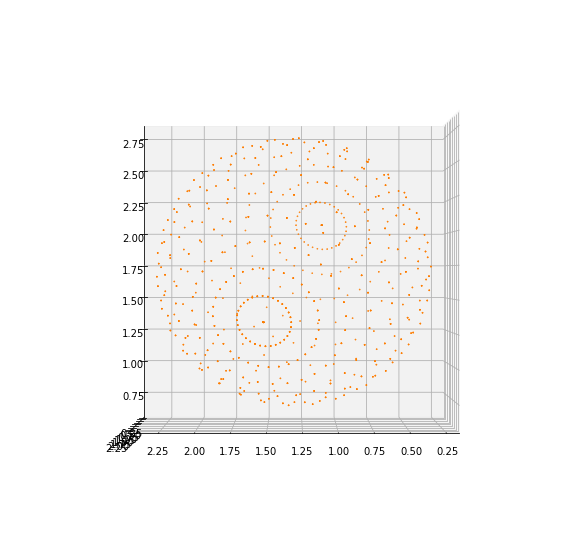

In [0]:
from pyntcloud import PyntCloud
import pandas as pd
cloud = PyntCloud.from_file("sphere_4.ply")
cloud.plot()

In [0]:
dop_mesh = cloud.get_sample("mesh_random", n=10000, as_PyntCloud=True)
dop_mesh.plot()
print(dop_mesh.points)
new_data = pd.DataFrame({"x": dop_mesh.points['x'], "y": dop_mesh.points['y'], "z":dop_mesh.points['z']}).to_numpy() 
print(new_data)

In [0]:
voxel_grid = VoxelGrid(new_data, x_y_z=[16,16,16])

In [0]:
print(voxel_grid.vector)

In [0]:
# point = cloud.get_mesh_vertices()

# dop_mesh = cloud.get_sample("mesh_random", n=10000, as_PyntCloud=True)
# # print(dop_mesh.points)
# x = dop_mesh.points['x'].values
# y = dop_mesh.points['y'].values
# z = dop_mesh.points['z'].values
# import numpy as np
# tmp = np.concatenate((x, y, z), axis=None)
# # print(tmp)

# # voxelgrid_id = dop_mesh.add_structure("voxelgrid", n_x=5, n_y=5, n_z=5)
# # voxelgrid = dop_mesh.structures[voxelgrid_id]
# # voxelgrid.get_feature_vector(mode="binary")
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# Axes3D.plot_trisurf(ax, x, y, z)

In [0]:
# !pip install open3d

In [0]:
# import numpy as np
# import open3d as o3d
# print("Testing IO for textured meshes ...")
# textured_mesh = o3d.io.read_triangle_mesh("untitled.obj")
# print(textured_mesh)
# o3d.io.write_triangle_mesh("untitled_.obj", textured_mesh, write_triangle_uvs=True)
# copy_textured_mesh = o3d.io.read_triangle_mesh('untitled_.obj')
# print(copy_textured_mesh)

Testing IO for textured meshes ...
geometry::TriangleMesh with 8 points and 12 triangles.
geometry::TriangleMesh with 8 points and 12 triangles.


In [0]:
# !rm *
!wget "https://ia802909.us.archive.org/19/items/3dMnist/3d-mnist.zip"
!unzip 3d-mnist.zip

In [3]:
!rm *
from google.colab import files
file = files.upload()
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!kaggle competitions download -c digit-recognizer
!kaggle datasets download -d daavoo/3d-mnist
!ls
!unzip 3d-mnist.zip

rm: cannot remove 'drive': Is a directory
rm: cannot remove 'sample_data': Is a directory


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 35.6MB/s]
 82% 5.00M/6.09M [00:00<00:00, 14.0MB/s]
100% 6.09M/6.09M [00:00<00:00, 15.4MB/s]
  0% 0.00/9.16M [00:00<?, ?B/s]
100% 9.16M/9.16M [00:00<00:00, 151MB/s]
 90% 137M/153M [00:03<00:00, 33.2MB/s]
100% 153M/153M [00:03<00:00, 47.5MB/s]
3d-mnist.zip  sample_data	     test.csv.zip
drive	      sample_submission.csv  train.csv.zip
Archive:  3d-mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


(30, 30)


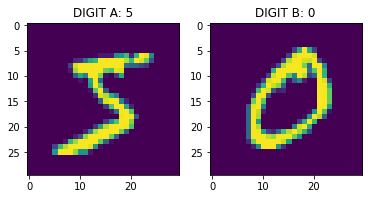

In [0]:
# import h5py
# import matplotlib.pyplot as plt

# with h5py.File("./train_point_clouds.h5", "r") as hf:    

#     a = hf["0"]
#     b = hf["1"]
    
#     digit_a = (a["img"][:], a["points"][:], a.attrs["label"]) 
#     digit_b = (b["img"][:], b["points"][:], b.attrs["label"])
#     print(a["img"][:].shape)


# plt.subplot(121)
# plt.title("DIGIT A: " + str(digit_a[2]))
# plt.imshow(digit_a[0])

# plt.subplot(122)
# plt.title("DIGIT B: " + str(digit_b[2]))
# plt.imshow(digit_b[0])


In [4]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam, SGD
from keras.callbacks import EarlyStopping
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
import sys

init_notebook_mode(connected=True)
%matplotlib inline
# import tensorflow.compat.v1 as tf # https://stackoverflow.com/questions/56820327/the-name-tf-session-is-deprecated-please-use-tf-compat-v1-session-instead
# tf.disable_v2_behavior()

Using TensorFlow backend.


In [0]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 16, 3)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 14, 14, 14, 8)     656       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 1, 1, 64)       0   

In [0]:
with h5py.File('./full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

In [0]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [0]:
print(x_train[0])

In [0]:
import sys
np.set_printoptions(threshold=sys.maxsize)
import numpy as np
from matplotlib import pyplot as plt
def plot(d=2, cmap="Oranges", axis=False):
  if d == 2:
      fig, axes= plt.subplots(int(np.ceil(self.n_z / 4)), 4, figsize=(8,8))
      plt.tight_layout()
      for i,ax in enumerate(axes.flat):
          if i >= len(x_train[0]):
              break
          im = ax.imshow(x_train[0], cmap=cmap, interpolation="none")
          ax.set_title("Level " + str(i))

      fig.subplots_adjust(right=0.8)
      cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
      cbar = fig.colorbar(im, cax=cbar_ax)
      cbar.set_label('NUMBER OF POINTS IN VOXEL')
plot()

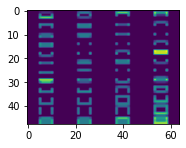

In [0]:
# print ("x_train shape: ", x_train.shape)
# print ("y_train shape: ", y_train.shape)

# print ("x_test shape:  ", x_test.shape)
# print ("y_test shape:  ", y_test.shape)
# np.set_printoptions(threshold=sys.maxsize)
aaa = np.array(x_train[0]).reshape(64, 64)

import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(aaa[16::])

# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(1111, projection='3d')

# Axes3D.plot_surface(ax, train_npy[100], train_npy[100], train_npy[0], rstride=1, cstride=1,linewidth=1, antialiased=True)

In [0]:
## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((train_x.shape[0], 4096, 3))
xtest = np.ndarray((test_x.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(train_x.shape[0]):
    xtrain[i] = add_rgb_dimention(train_x[i])
for i in range(test_x.shape[0]):
    xtest[i] = add_rgb_dimention(test_x[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(train_x.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(test_x.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = keras.utils.to_categorical(train_y, 3)
y_test = keras.utils.to_categorical(test_y, 3)

In [0]:
y_train.shape

(10000, 10)

In [0]:
# ## input layer
# input_layer = Input((16, 16, 16, 3))

# ## convolutional layers
# conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

# ## add max pooling to obtain the most imformatic features
# pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
# conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
# pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

# ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
# pooling_layer2 = BatchNormalization()(pooling_layer2)
# flatten_layer = Flatten()(pooling_layer2)

# ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
# ## add dropouts to avoid overfitting / perform regularization
# dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=10, activation='softmax')(dense_layer2)

# ## define the model with input layer and output layer
# model = Model(inputs=input_layer, outputs=output_layer)
# model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 16, 16, 3)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 14, 14, 14, 8)     656       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 1, 1, 1, 64)       0   

In [10]:
# ## input layer
# input_layer = Input((16, 16, 16, 3))

# ## convolutional layers
# conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(input_layer)
# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(conv_layer1)

# ## add max pooling to obtain the most imformatic features
# pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3),use_bias=False, padding='Same')(pooling_layer1)
# conv_layer3 = BatchNormalization()(conv_layer3)
# active = Activation("relu")(conv_layer3)

# conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3),use_bias=False, padding='Same')(conv_layer3)
# batch_norm = BatchNormalization()(conv_layer4)
# active = Activation("relu")(batch_norm)

# pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(active)
# drop = Dropout(0.25)(pooling_layer2)

# ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
# # pooling_layer2 = BatchNormalization()(pooling_layer2)
# flatten_layer = Flatten()(drop)

# ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
# ## add dropouts to avoid overfitting / perform regularization
# dense_layer1 = Dense(units=4096, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.5)(dense_layer1)
# dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.5)(dense_layer2)
# output_layer = Dense(units=10, activation='softmax')(dense_layer2)

# ## define the model with input layer and output layer
# model = Model(inputs=input_layer, outputs=output_layer)
# model.summary()
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(input_layer)
conv_layer2 = Conv3D(filters=8, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(conv_layer1)
batch_norm = BatchNormalization()(conv_layer2)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(batch_norm)
drop = Dropout(0.25)(pooling_layer1)


## convolutional layers
conv_layer3 = Conv3D(filters=16, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(drop)
conv_layer4 = Conv3D(filters=16, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(conv_layer3)
batch_norm = BatchNormalization()(conv_layer4)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(batch_norm)
drop2 = Dropout(0.25)(pooling_layer1)


## convolutional layers
conv_layer5 = Conv3D(filters=32, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(drop2)
conv_layer6 = Conv3D(filters=32, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(conv_layer5)
batch_norm = BatchNormalization()(conv_layer6)

pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(batch_norm)
drop3 = Dropout(0.25)(pooling_layer1)

## convolutional layers
conv_layer7 = Conv3D(filters=64, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(drop3)
conv_layer8 = Conv3D(filters=64, kernel_size=(3, 3, 3),use_bias=False, activation='relu', padding='Same')(conv_layer7)
batch_norm = BatchNormalization()(conv_layer8)

pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(batch_norm)
drop4 = Dropout(0.25)(pooling_layer1)


flatten_layer = Flatten()(drop4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=4096, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.5)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 16, 16, 3)     0         
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 16, 16, 16, 8)     648       
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 16, 16, 16, 8)     1728      
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 16, 8)     32        
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 8, 8, 8, 8)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 8, 8)        0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 8, 8, 16)       3456

In [0]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary

<bound method Network.summary of <keras.engine.training.Model object at 0x7feee2f9ddd8>>

In [11]:
import tensorflow as tf
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-5)

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['acc'])
history = model.fit(x=xtrain, y=y_train, batch_size=64, epochs=80, validation_split=0.15, callbacks=[early_stopping, learning_rate_reduction])

Train on 8500 samples, validate on 1500 samples
Epoch 1/80
8500/8500 [==============================] - 15s 2ms/step - loss: 2.3140 - acc: 0.1381 - val_loss: 2.2928 - val_acc: 0.1060
Epoch 2/80
8500/8500 [==============================] - 8s 928us/step - loss: 1.9788 - acc: 0.2682 - val_loss: 5.1416 - val_acc: 0.1160
Epoch 3/80
8500/8500 [==============================] - 8s 929us/step - loss: 1.7027 - acc: 0.3667 - val_loss: 1.9088 - val_acc: 0.3847
Epoch 4/80
8500/8500 [==============================] - 8s 926us/step - loss: 1.5197 - acc: 0.4522 - val_loss: 3.1649 - val_acc: 0.3260
Epoch 5/80
8500/8500 [==============================] - 8s 928us/step - loss: 1.3549 - acc: 0.5111 - val_loss: 2.3776 - val_acc: 0.2567
Epoch 6/80
8500/8500 [==============================] - 8s 927us/step - loss: 1.2576 - acc: 0.5551 - val_loss: 1.4593 - val_acc: 0.5127
Epoch 7/80
8500/8500 [==============================] - 8s 930us/step - loss: 1.1649 - acc: 0.5899 - val_loss: 2.3821 - val_acc: 0.3173
E

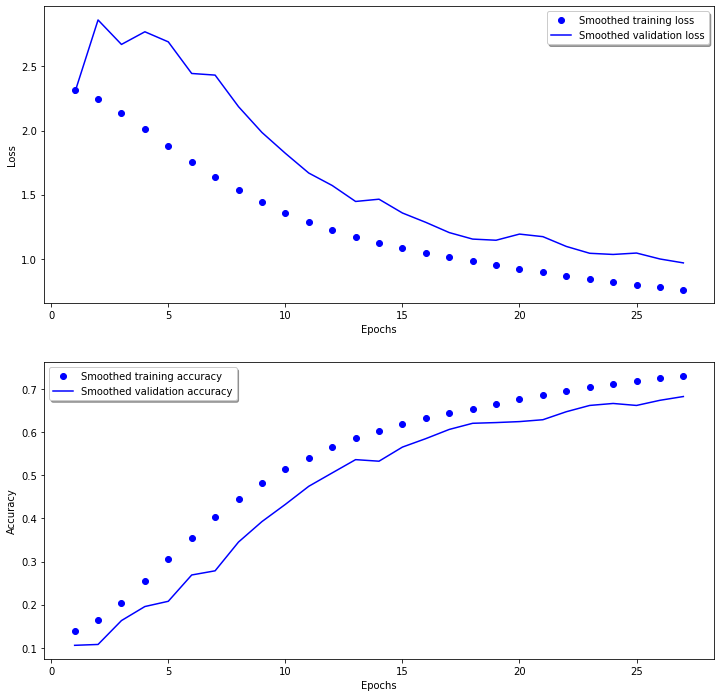

In [14]:
# Visualisation:
plot_smoothed_learning_curves(history)

In [0]:

import matplotlib.pyplot as plt
import numpy
def plot_smoothed_learning_curves(history):
    val_loss = history.history['val_loss']#[-30:-1] #Uncomment if you want to see only the last epochs
    loss = history.history['loss']#[-30:-1]
    acc = history.history['acc']#[-30:-1]
    val_acc = history.history['val_acc']#[-30:-1]
    
    epochs = range(1, len(acc)+1 )
    
    # Plot the loss and accuracy curves for training and validation 
    fig, ax = plt.subplots(2,1, figsize=(12, 12))
    ax[0].plot(epochs, smooth_curve(loss), 'bo', label="Smoothed training loss")
    ax[0].plot(epochs, smooth_curve(val_loss), 'b', label="Smoothed validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].plot(epochs, smooth_curve(acc), 'bo', label="Smoothed training accuracy")
    ax[1].plot(epochs, smooth_curve(val_acc), 'b',label="Smoothed validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    return

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points



In [0]:
del model

In [0]:

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)


model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['acc'])
history = model.fit(x=xtrain, y=y_train, batch_size=64, epochs=40, validation_split=0.1, callbacks=[early_stopping])

In [0]:
# Visualisation:
plot_smoothed_learning_curves(history)

In [0]:
import tensorflow as tf

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

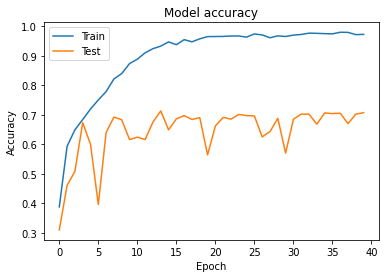

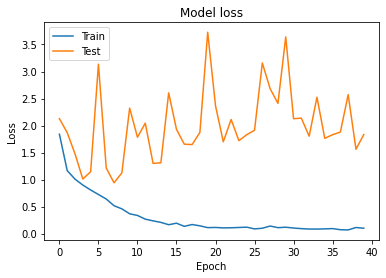

In [0]:
import matplotlib.pyplot as plt
import numpy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')k
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
# model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
# model.fit(x=xtrain, y=y_train, batch_size=128, epochs=50, validation_split=0.2)

In [0]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
pred = keras.utils.to_categorical(pred, num_classes=10)

accuracy = np.sum(pred * y_test) / len(y_test)
accuracy*100

71.45

In [0]:
model.save('./drive/My Drive/figure_w.h5')

In [0]:
del model

In [0]:
from keras.models import load_model
model = load_model('./drive/My Drive/figure_w.h5')

In [0]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
pred = keras.utils.to_categorical(pred, num_classes=3)

accuracy = np.sum(pred * y_test) / len(y_test)
accuracy*100

99.6